# Aircraft Detection with YOLOv8

In this notebook we will demonstrate how to use and fine-tune the YOLOv8 model to detect aircrafts on the ground.

The [YOLOv8](https://github.com/ultralytics/ultralytics) architecture is developed by Ultralytics and you can easilly install all the required tools by runnnig:
```console
pip install ultralytics
```

Now let's check that everything has been installed correctly.

In [1]:
!yolo check

Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
Setup complete ✅ (8 CPUs, 7.7 GB RAM, 91.2/1006.9 GB disk)

OS                  Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Environment         Linux
Python              3.10.12
Install             pip
RAM                 7.71 GB
CPU                 Intel Xeon E5-1620 v3 3.50GHz
CUDA                12.1

numpy               ✅ 1.26.4<2.0.0,>=1.23.0
matplotlib          ✅ 3.9.1>=3.3.0
opencv-python       ✅ 4.10.0.84>=4.6.0
pillow              ✅ 10.4.0>=7.1.2
pyyaml              ✅ 5.4.1>=5.3.1
requests            ✅ 2.32.3>=2.23.0
scipy               ✅ 1.14.0>=1.4.1
torch               ✅ 2.4.0+cu121>=1.8.0
torchvision         ✅ 0.19.0+cu121>=0.9.0
tqdm                ✅ 4.66.4>=4.64.0
psutil              ✅ 6.0.0
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.2.2>=1.1.4
seaborn             ✅ 0.13.2>=0.11.0
ultralytics-thop    ✅ 2.0.0>=2.0.0


In [2]:
import ast
import cv2
import numpy as np
import os
import pandas as pd
import random
import torch

from collections import Counter
from tqdm.notebook import tqdm
from ultralytics import YOLO

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

### Dataset

We wil lbe working with the [Airbus](https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset) satellite dataset developed by Aribus Defense and Space Intelligence to detect grounded aircrafts.

The dataset contains 103 extract of satellite imagery at roughly 50 cm resolution. Each each image is stored as a JPEG file of size 2560 x 2560 pixels (i.e. 1280 meters on ground). The locations are various airports worldwide. 

All aircrafts have been annotated with bounding boxes on the provided imagery. The annotations are provided in the form of closed GeoJSON polygons.

Number of samples: 103
Image shape:       (2560, 2560, 3)


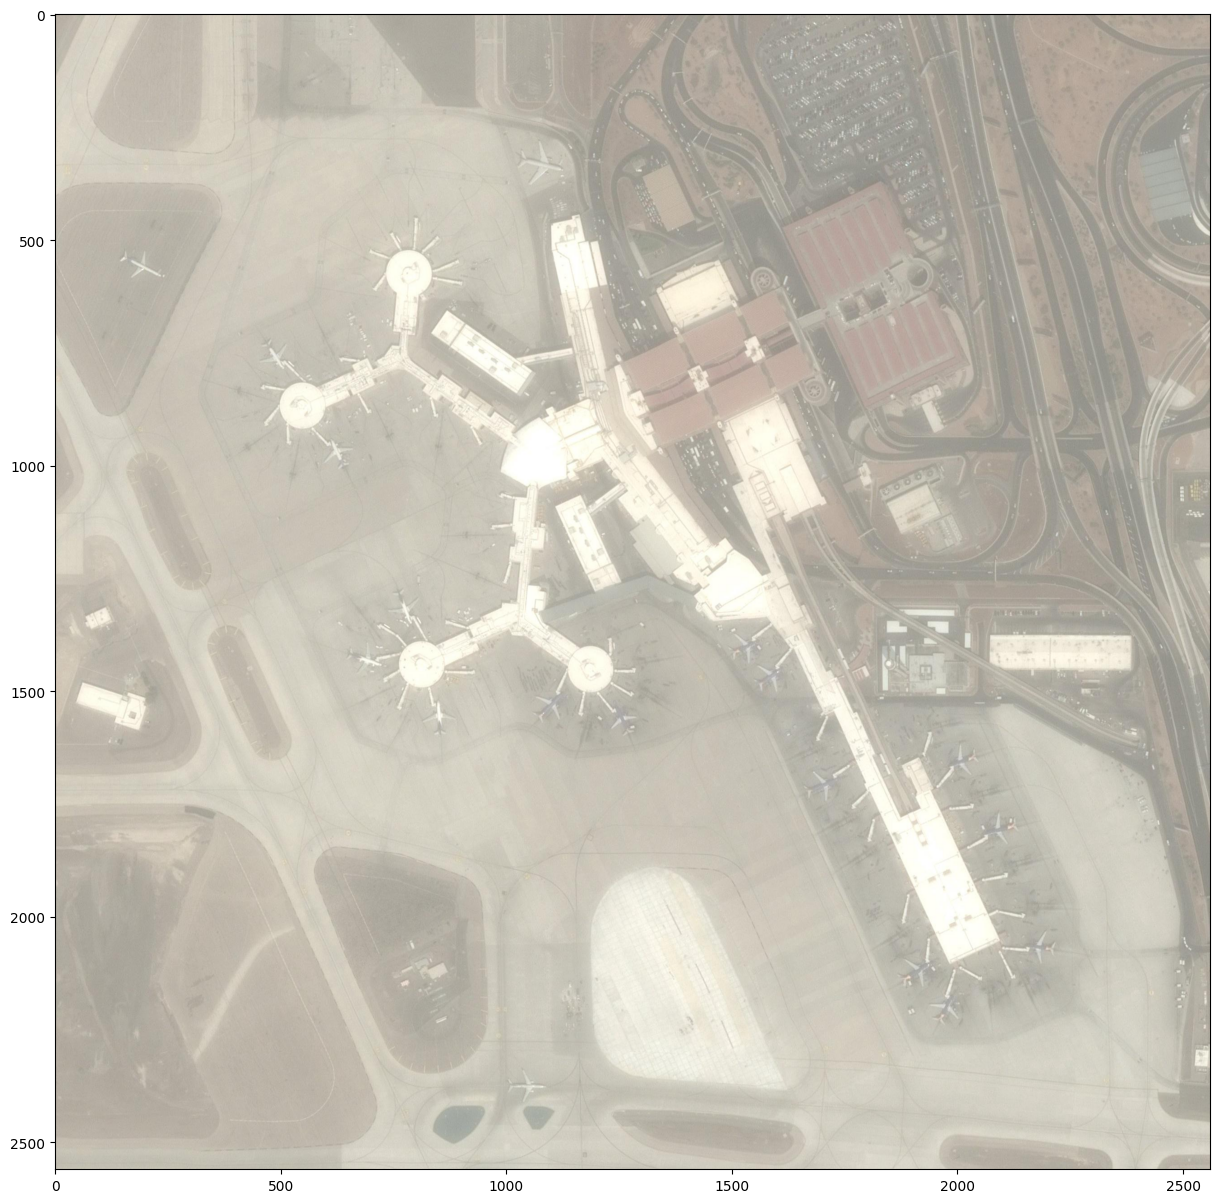

In [3]:
def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

data_folder = './datasets/'
imfiles = os.listdir(os.path.join(data_folder, 'images'))
imfiles = [os.path.join(data_folder, 'images', f) for f in imfiles if os.path.splitext(f)[-1] == '.jpg']

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

plt.imshow(image)

print('Number of samples:', len(imfiles))
print('Image shape:      ', image.shape)

Check that all images have the same size.

In [4]:
assert all(cv2.imread(imfile).shape == (rows, cols, channels) for imfile in tqdm(imfiles))

  0%|          | 0/103 [00:00<?, ?it/s]

Now let's load the file containing the annotations. When you open the csv file, you will see that the geometry information is provided as a string. We need to convert it to a more "ML friendly" format. This can be achieved by using a custom converter function.

In [5]:
def geo_to_ndarray(x): 
    return np.array(ast.literal_eval(x))

annotations = pd.read_csv('./datasets/data/annotations.csv', 
                          converters={'geometry': geo_to_ndarray})
annotations

id                                  image_id  \
0        1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
1        2  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
2        3  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
3        4  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
4        5  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
...    ...                                       ...   
3420  3421  48ef8e15-a43c-406b-9d3c-e815164b96d1.jpg   
3421  3422  48ef8e15-a43c-406b-9d3c-e815164b96d1.jpg   
3422  3423  48ef8e15-a43c-406b-9d3c-e815164b96d1.jpg   
3423  3424  48ef8e15-a43c-406b-9d3c-e815164b96d1.jpg   
3424  3425  48ef8e15-a43c-406b-9d3c-e815164b96d1.jpg   

                                               geometry               class  
0     [[135, 522], [245, 522], [245, 600], [135, 600...            Airplane  
1     [[1025, 284], [1125, 284], [1125, 384], [1025,...            Airplane  
2     [[1058, 1503], [1130, 1503], [1130, 1568], [10...            Airplane  
3     [[813, 1518], [885, 1518], [885, 1604], [813, ...            Airplane  
4     [[594, 938], [657, 938], [657, 1012], [594, 10...            Airplane  
...                                                 ...                 ...  
3420  [[1059, 393], [1187, 393], [1187, 522], [1059,...            Airplane  
3421  [[932, 355], [1028, 355], [1028, 461], [932, 4...            Airplane  
3422  [[2461, 244], [2560, 244], [2560, 345], [2461,...  Truncated_airplane  
3423  [[1820, 344], [1937, 344], [1937, 443], [1820,...            Airplane  
3424  [[2239, 0], [2336, 0], [2336, 28], [2239, 28],...  Truncated_airplane  

[3425 rows x 4 columns]

We see a total of 3425 annotated aircarfts. Each aircraft is annotaed with a bounding box in a closed format. Let's now check that there are no objects other than aircrafts.

In [6]:
Counter(annotations['class'])

Counter({'Airplane': 3316, 'Truncated_airplane': 109})

Also let's make sure that all geometry objects are closed bounding boxes. This means, they contains 5 points and the coordinates of the origin (i.e. the first point) and the last points are the same.

In [7]:
assert all(len(geo) == 5 for geo in annotations['geometry'])
assert all(np.array_equal(geo[0, :], geo[-1, :]) for geo in annotations.geometry)

It is always important to visualize the data and annotation to make sure that we properly understand and handle the format and that the annotations are, in fact, correct.

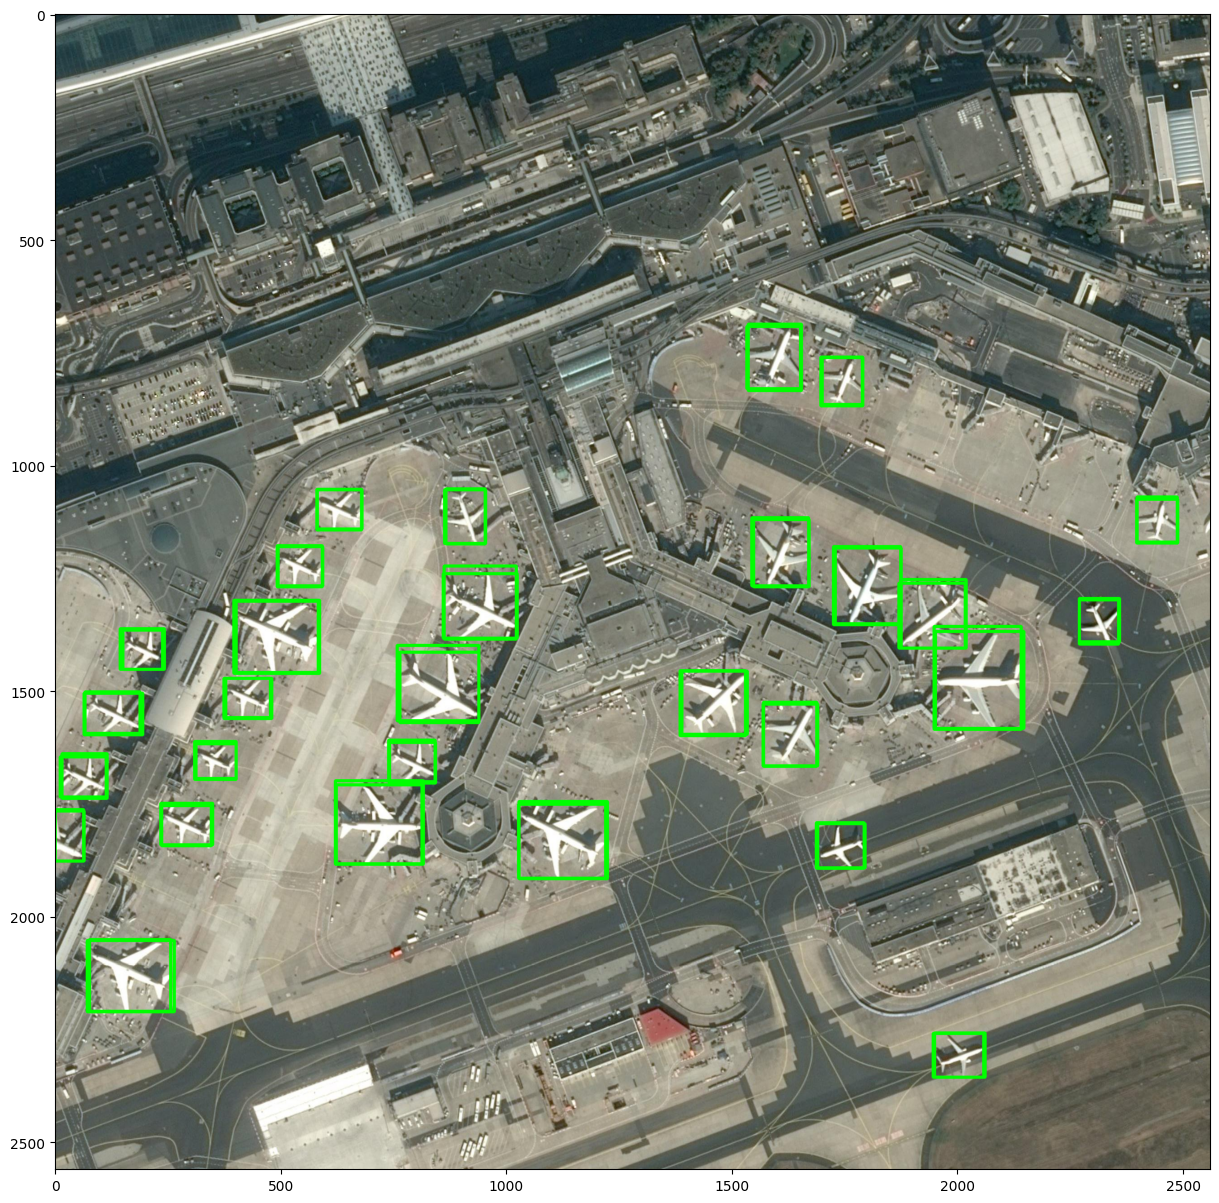

In [8]:
sample = random.choice(imfiles)
image = imread(sample)

labels = annotations[annotations.image_id == os.path.basename(sample)]
points = [geo.reshape((-1, 1, 2)) for geo in labels.geometry]
cv2.polylines(image, points, isClosed=True, color=(0, 255, 0), thickness=5)

plt.imshow(image)

### Data Format Conversion

In order to use the YOLOv8 training tools efficiently, we need to use the [YOLOv8 data format](https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format).

In addition, we will split each into 512x512 crops. This is commonly done to be able to train the model and not incur into memory problems. Therefore, we create a separate dataset with image crops. We will need to adjust the bounding boxes as well.

In [9]:
def recompute_box_coors(box, x_origin, y_origin, width, height, threshold):
    """Recompute box coordinates to new origin
    
    Args:
        box (np.ndarray): Bounding box coordinates in form (x_min, y_min, x_max, y_max).
        x_origin (int): X coordinate of the origin of the new coordinate system.
        y_origin (int): Y coordinate of the origin of the new coordinate system.
        width (int): Width of the new coordinate system. Recomputed box coordinates
            that would fall beyond will be truncated.
        threshold (float): Rejection ratio of bounding box after truncation. Recomputed
            boxes that are heavily truncated will be discarded.
            
    Returns:
        (tuple): Recomputed bounding boxes in YOLOv8 data format.
        
    """
    # Recompute bounds coordinates to new reference
    x_min, y_min, x_max, y_max = box
    x_min, y_min, x_max, y_max = x_min - x_origin, y_min - y_origin, x_max - x_origin, y_max - y_origin

    # Return None if the box does not lie within image crop
    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None
    
    # Truncate box x coordinates if necessary
    x_max_trunc = min(x_max, width)
    x_min_trunc = max(x_min, 0)
    # Skip if truncate too much
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < threshold:
        return None

    # Repeat for y coordinates
    y_max_trunc = min(y_max, width) 
    y_min_trunc = max(y_min, 0) 
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < threshold:
        return None
        
    # Convert to YOLOv8 format
    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height
    
    return (0, x_center, y_center, x_extend, y_extend)

In [10]:
def get_boxes(geometry):
    return np.min(geometry[:, 0]), np.min(geometry[:, 1]), np.max(geometry[:, 0]), np.max(geometry[:, 1])

annotations.loc[:,'boxes'] = annotations.loc[:,'geometry'].apply(get_boxes)
annotations.head(10)

id                                  image_id  \
0   1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
1   2  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
2   3  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
3   4  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
4   5  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
5   6  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
6   7  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
7   8  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
8   9  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   
9  10  4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg   

                                            geometry     class  \
0  [[135, 522], [245, 522], [245, 600], [135, 600...  Airplane   
1  [[1025, 284], [1125, 284], [1125, 384], [1025,...  Airplane   
2  [[1058, 1503], [1130, 1503], [1130, 1568], [10...  Airplane   
3  [[813, 1518], [885, 1518], [885, 1604], [813, ...  Airplane   
4  [[594, 938], [657, 938], [657, 1012], [594, 10...  Airplane   
5  [[451, 725], [524, 725], [524, 798], [451, 798...  Airplane   
6  [[1543, 1437], [1614, 1437], [1614, 1497], [15...  Airplane   
7  [[1485, 1370], [1561, 1370], [1561, 1437], [14...  Airplane   
8  [[1968, 1624], [2053, 1624], [2053, 1687], [19...  Airplane   
9  [[1659, 1674], [1733, 1674], [1733, 1746], [16...  Airplane   

                      boxes  
0      (135, 522, 245, 600)  
1    (1025, 284, 1125, 384)  
2  (1058, 1503, 1130, 1568)  
3    (813, 1518, 885, 1604)  
4     (594, 938, 657, 1012)  
5      (451, 725, 524, 798)  
6  (1543, 1437, 1614, 1497)  
7  (1485, 1370, 1561, 1437)  
8  (1968, 1624, 2053, 1687)  
9  (1659, 1674, 1733, 1746)

#### Data Splitting

Split data into train and validation set and prepare the folders for storing the images and annotations.

In [11]:
fnames = list(annotations['image_id'].unique())
np.random.shuffle(fnames)
train_split = fnames[0:int(len(fnames)*0.8)]

print('Num samples', len(fnames))
print('Train split', len(train_split))
print('Val split  ', len(fnames) - len(train_split))

Num samples 103
Train split 82
Val split   21


In [12]:
folder_crops = {'train': './datasets/train/images/',
                'val': './datasets/val/images/'}

folder_labels = {'train': './datasets/train/labels/',
                 'val': './datasets/val/labels/'}

for folders in [folder_crops, folder_labels]:
    for _, folder in folders.items():
        if not os.path.isdir(folder):
            os.makedirs(folder)

Create image crops and adjust the corresponding labels. The labels will be stored in seperate txt files (one for each image), as required by YOLOv8 format.

In [13]:
crop_size = 512
crop_overlap = 64
trunc_th = 0.3
step = crop_size - crop_overlap


for imfile in (imfiles):    
    image = cv2.imread(imfile)
    folder = 'train' if os.path.basename(imfile) in train_split else 'val'

    # Get annotations for image
    labels = annotations[annotations['image_id'] == os.path.basename(imfile)]
    img_id = os.path.splitext(os.path.basename(imfile))[0]    
 
    # Extract crops
    for x_start in tqdm(np.arange(0, cols - crop_size, step)):
        for y_start in np.arange(0, rows - crop_size, step):

            x_end = x_start + crop_size
            y_end = y_start + crop_size
            
            filename_crop = os.path.join(folder_crops[folder],
                                         img_id + '_' + str(x_start) + '_' + str(y_start) + '.jpg')
            filename_label = os.path.join(folder_labels[folder],
                                          img_id + '_' + str(x_start) + '_' + str(y_start) + '.txt')
                                        
            crop = image[y_start:y_end, x_start:x_end, :]
            assert crop.shape == (crop_size, crop_size, channels)                
            cv2.imwrite(filename_crop, crop)

            boxes = [recompute_box_coors(boxes, x_start, y_start, crop_size, crop_size, trunc_th)
                     for boxes in labels['boxes']]
            boxes = [box for box in boxes if box is not None]            

            # save labels
            with open(filename_label, 'w+') as f:
                for box in boxes:
                    f.write(' '.join(str(x) for x in box) + '\n')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Let us visualize the crops and the corresponding labels to check that the cropping has worked properly.

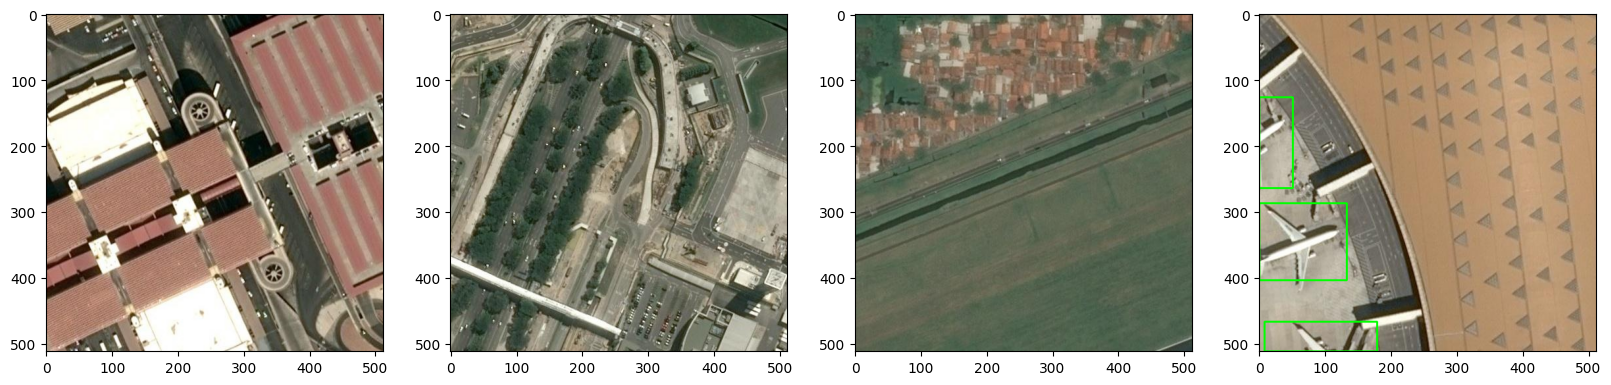

In [14]:
for idx, sample in enumerate(np.random.choice(os.listdir(folder_crops['train']), 4)):
    
    # Load image and corresponding labels
    image = imread(os.path.join(folder_crops['train'], sample))
    with open(os.path.join(folder_labels['train'], sample.replace('.jpg', '.txt')), 'r') as f:
        labels = f.readlines()

    for box in labels:
        box = np.array([d for d in box.split(' ')], dtype=np.float32)
        
        # Undo coordinate normalization
        x_center = box[1] * crop_size
        y_center = box[2] * crop_size

        width = box[3] * crop_size
        height = box[4] * crop_size

        # Convert from YOLOv8 format to OpenCV rectangle format
        x_start, y_start = int(x_center - width/2), int(y_center - height/2)
        x_end, y_end = int(x_center + width/2), int(y_center + height/2)

        cv2.rectangle(image, (x_start, y_start), (x_end, y_end), color=(0, 255, 0), thickness=2)

    plt.subplot(1,4,idx+1), plt.imshow(image)

### YOLOv8

Let's now load the detection model. There are different model [sizes](https://github.com/ultralytics/ultralytics) pretrained on [COCO](https://docs.ultralytics.com/datasets/detect/coco/) that you can chose from. We will use the small model here.

In [95]:
model = YOLO("./datasets/data/yolov8s.pt")
model.info()

YOLOv8s summary: 225 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(225, 11166560, 0, 28.816844800000002)

In [96]:
root

'./data/projects/'

In [97]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [98]:
# results[0].boxes


0: 640x640 1 toilet, 38.8ms
Speed: 4.6ms preprocess, 38.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 airplanes, 48.8ms
Speed: 5.0ms preprocess, 48.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 55.3ms
Speed: 14.4ms preprocess, 55.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 45.3ms
Speed: 4.2ms preprocess, 45.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


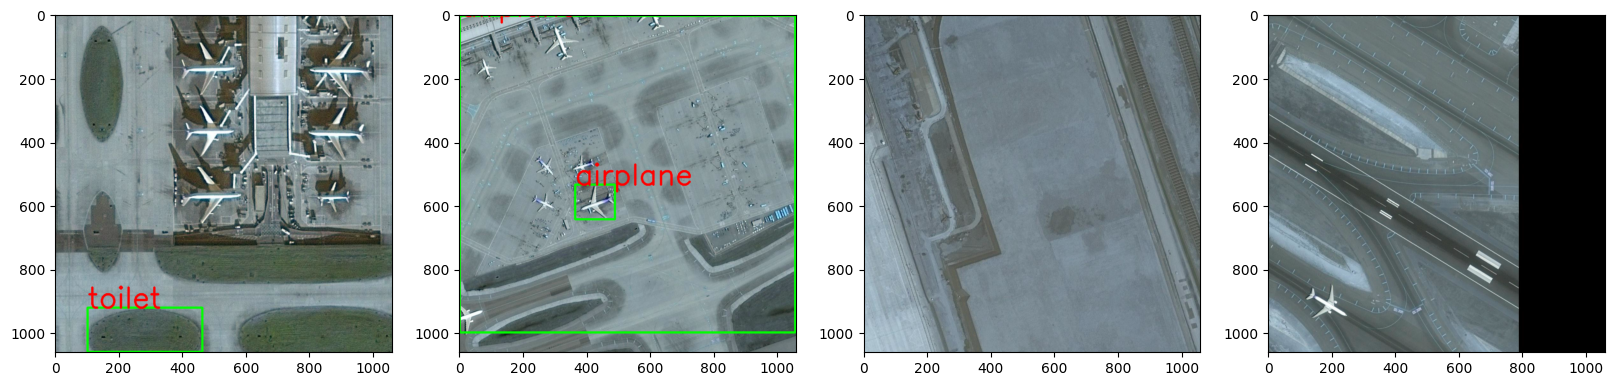

In [99]:
for idx, sample in enumerate(np.random.choice(imfiles, 4)):
    image = cv2.imread(sample)
    image = image[1500:, 1500:, :]

    result = model.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 255, 0), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 6, cv2.LINE_AA)

    plt.subplot(1,4,idx+1), plt.imshow(image)

### Train YOLOv8 on Custom Dataset

In [16]:
config = """
# train and val datasets (image directory or *.txt file with image paths)
train: ./datasets/train/images/
val: ./datasets/val/images

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

with open("./datasets/data/projects/data.yaml", "w") as f:
    f.write(config)

Training settings:
    https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters

In [17]:
root = "./data/projects/"
!yolo task=detect mode=train model=datasets/data/yolov8s.pt data=datasets/data/projects/data.yaml epochs=10 imgsz=512 mosaic=0.0 flipud=0.5 scale=0.0

Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
engine/trainer: task=detect, mode=train, model=datasets/data/yolov8s.pt, data=datasets/data/projects/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

In [43]:
retrained = YOLO('./datasets/data/projects/runs/detect/train4/weights/best.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'data/projects/runs/detect/train4/weights/best.pt'

In [ ]:
for idx, sample in enumerate(np.random.choice(imfiles, 4)):
    image = cv2.imread(sample)
    image = image[1800:, 1800:, :]

    result = model.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 255, 0), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 6, cv2.LINE_AA)
        
    result = retrained.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 0, 255), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 6, cv2.LINE_AA)

    plt.subplot(1,4,idx+1), plt.imshow(image)